<a href="https://colab.research.google.com/github/Falconwatch/MKBhack/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!wget https://github.com/Falconwatch/MKBhack/raw/main/data/train.csv
!wget https://github.com/Falconwatch/MKBhack/raw/main/data/test.csv

--2021-11-09 18:50:14--  https://github.com/Falconwatch/MKBhack/raw/main/data/train.csv
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Falconwatch/MKBhack/main/data/train.csv [following]
--2021-11-09 18:50:15--  https://raw.githubusercontent.com/Falconwatch/MKBhack/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9253323 (8.8M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   8.82M  --.-KB/s    in 0.1s    

2021-11-09 18:50:16 (77.5 MB/s) - ‘train.csv’ saved [9253323/9253323]

--2021-11-09 18:50:16--  https://github.com/Falconwatch/MKBhack

In [25]:
import pandas as pd
import datetime
import missingno as msno
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier

In [26]:
parser = lambda date: None if pd.isna(date) else datetime.datetime.strptime(date, '%d%b%Y:%H:%M:%S')

train = pd.read_csv("train.csv", encoding='cp1251', sep=';',
                    parse_dates=["SIGN_DATE", "DATEFIRSTREG", "TAXREG_REGDATE", "BIRTHDATE", "TAXREGPAY_REGDATE"], 
                    date_parser=parser)
test = pd.read_csv("test.csv", encoding='cp1251', sep=';',
                    parse_dates=["SIGN_DATE", "DATEFIRSTREG", "TAXREG_REGDATE", "BIRTHDATE", "TAXREGPAY_REGDATE"], 
                   date_parser=parser)

train["is_train"] = 1
test["is_train"] = 0

data = pd.concat([train, test])

# Общие преобразования

## переход к формату клиент - дата **выдачи**

### Разметка дефолта

In [29]:
#Клиент на дату с указание таргета и числа договоров в дату
client_data = data.groupby(["id_client", "SIGN_DATE"]).agg({"TARGET":"mean", "id_client":"count"})
client_data.columns = ["target", "issues_this_day"]
client_data.head(2)

,,target,issues_this_day
id_client,SIGN_DATE,,
1,2018-05-15,1.0,1
2,2018-02-28,0.0,1


In [30]:
# Дефолт не на уровне клиента. 14 таких клиентов
client_data[(client_data["target"]>0) & (client_data["target"]<1)].shape

(14, 2)

### Обрабатываем все нумерик фичи

In [31]:
client_data_numeric = data.groupby(["id_client", "SIGN_DATE"]).max(numeric_only=True)
client_data_numeric = client_data_numeric.drop(["id_contract"], axis=1)
client_data_numeric.head(2)

,,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,...,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,AGE,is_train
id_client,SIGN_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2018-05-15,0,1.0,10000.0,NaN,10000.0,NaN,NaN,NaN,NaN,7035000.0,NaN,NaN,NaN,NaN,7035000.0,NaN,6121000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,924000.0,NaN,924000.0,NaN,NaN,7045000.0,7045000.0,NaN,32078000.0,27921000.0,4157000.0,NaN,NaN,4157000.0,...,0.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,5.0,22.0,10.0,22265508.0,242.0,10.0,111.0,90.0,104344311.0,NaN,NaN,NaN,NaN,1
2,2018-02-28,0,0.0,14626000.0,NaN,14414000.0,NaN,212000.0,NaN,NaN,14939000.0,8521000.0,NaN,6395000.0,NaN,23000.0,NaN,18901000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10664000.0,8995000.0,1669000.0,NaN,NaN,29565000.0,29565000.0,NaN,28874000.0,26330000.0,2544000.0,NaN,NaN,2126000.0,...,0.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,16765.0,0.0,1.0,0.0,1.0,16765.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1.0,13.0,13.0,41353573.0,88.0,2.0,41.0,41.0,178087244.0,NaN,NaN,1.0,NaN,1


### Обрабатываем строковые фичи

In [32]:
dts = data.dtypes
object_columns = dts[dts=="object"].index.values
object_columns

array(['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'WORKERSRANGE',
       'OKVED_CODE', 'SEX_NAME', 'CITIZENSHIP_NAME'], dtype=object)

In [33]:
for oc in object_columns:
  data[oc] = data[oc].astype(str)

In [34]:
client_obj_features_list = list()
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["OKFS_GROUP"].max())
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["OKOPF_GROUP"].max())
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["OKOGU_GROUP"].max())
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["WORKERSRANGE"].max())
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["OKVED_CODE"].max())
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["SEX_NAME"].max())
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["CITIZENSHIP_NAME"].max())

In [35]:
client_obj_features = pd.concat(client_obj_features_list, axis=1)

### Обрабатываем даты

In [58]:
dts = data.dtypes
date_columns = dts[dts=='<M8[ns]'].index.values
date_columns

array(['SIGN_DATE', 'DATEFIRSTREG', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE',
       'BIRTHDATE'], dtype=object)

In [61]:
days_columns = list()
for dc in date_columns:
  days_columns.append(dc+"_days")
  data[dc+"_days"] = data["SIGN_DATE"]-data[dc]

In [73]:
client_dates_features = data.groupby(["id_client", "SIGN_DATE"])[days_columns].max().apply(lambda x: x.dt.days)
client_dates_features.head(2)

,,SIGN_DATE_days,DATEFIRSTREG_days,TAXREG_REGDATE_days,TAXREGPAY_REGDATE_days,BIRTHDATE_days
id_client,SIGN_DATE,,,,,
1,2018-05-15,0,5108.0,5108.0,21319.0,NaN
2,2018-02-28,0,6988.0,5669.0,21243.0,NaN


In [74]:
client_dates_features["firstreg_taxreg_days"] = client_dates_features["DATEFIRSTREG_days"] - client_dates_features["TAXREG_REGDATE_days"]
client_dates_features.head(2)

,,SIGN_DATE_days,DATEFIRSTREG_days,TAXREG_REGDATE_days,TAXREGPAY_REGDATE_days,BIRTHDATE_days,firstreg_taxreg_days
id_client,SIGN_DATE,,,,,,
1,2018-05-15,0,5108.0,5108.0,21319.0,NaN,0.0
2,2018-02-28,0,6988.0,5669.0,21243.0,NaN,1319.0


### Формируем итоговый набор по клиенту

In [75]:
t = client_data.merge(client_data_numeric, left_index=True, right_index=True)
t = t.merge(client_dates_features, left_index=True, right_index=True)
final_client_data = t.merge(client_obj_features, left_index=True, right_index=True)

In [76]:
final_client_data.head(2)

,,target,issues_this_day,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,...,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,AGE,is_train,SIGN_DATE_days,DATEFIRSTREG_days,TAXREG_REGDATE_days,TAXREGPAY_REGDATE_days,BIRTHDATE_days,firstreg_taxreg_days,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,WORKERSRANGE,OKVED_CODE,SEX_NAME,CITIZENSHIP_NAME
id_client,SIGN_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2018-05-15,1.0,1,0,1.0,10000.0,NaN,10000.0,NaN,NaN,NaN,NaN,7035000.0,NaN,NaN,NaN,NaN,7035000.0,NaN,6121000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,924000.0,NaN,924000.0,NaN,NaN,7045000.0,7045000.0,NaN,32078000.0,27921000.0,4157000.0,NaN,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,5.0,22.0,10.0,22265508.0,242.0,10.0,111.0,90.0,104344311.0,NaN,NaN,NaN,NaN,1,0,5108.0,5108.0,21319.0,NaN,0.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,6 .. 10,43.11,nan,nan
2,2018-02-28,0.0,1,0,0.0,14626000.0,NaN,14414000.0,NaN,212000.0,NaN,NaN,14939000.0,8521000.0,NaN,6395000.0,NaN,23000.0,NaN,18901000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10664000.0,8995000.0,1669000.0,NaN,NaN,29565000.0,29565000.0,NaN,28874000.0,26330000.0,2544000.0,NaN,...,16765.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1.0,13.0,13.0,41353573.0,88.0,2.0,41.0,41.0,178087244.0,NaN,NaN,1.0,NaN,1,0,6988.0,5669.0,21243.0,NaN,1319.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,6 .. 10,31.09,nan,nan


## Чистка аномалий

In [77]:
#клиент 11209 то ИП, то ЮЛ и при этом существует только в трейне - дропаем
final_client_data = final_client_data.drop(11209)

## Генерация фичей

In [78]:
#выдано до этого дня
issues_cumsum = final_client_data.groupby("id_client")["issues_this_day"].transform(pd.Series.cumsum)
final_client_data["issues_cumsum"] = issues_cumsum - final_client_data["issues_this_day"]

# Разбиение на ИП/ЮЛ
Посмотрим целесообразность разбиения на две модели

In [79]:
ip_data = final_client_data.loc[final_client_data["IP_flag"]==1]
ul_data = final_client_data.loc[final_client_data["IP_flag"]==0]

In [80]:
#msno.bar(ip_data)
ip_data["TARGET"].mean()

0.29518469656992086

In [81]:
#msno.bar(ul_data)
ul_data["TARGET"].mean()

0.3570138943402151

Ожидаемо видим необходимость разделить данные на два потока

# ИП

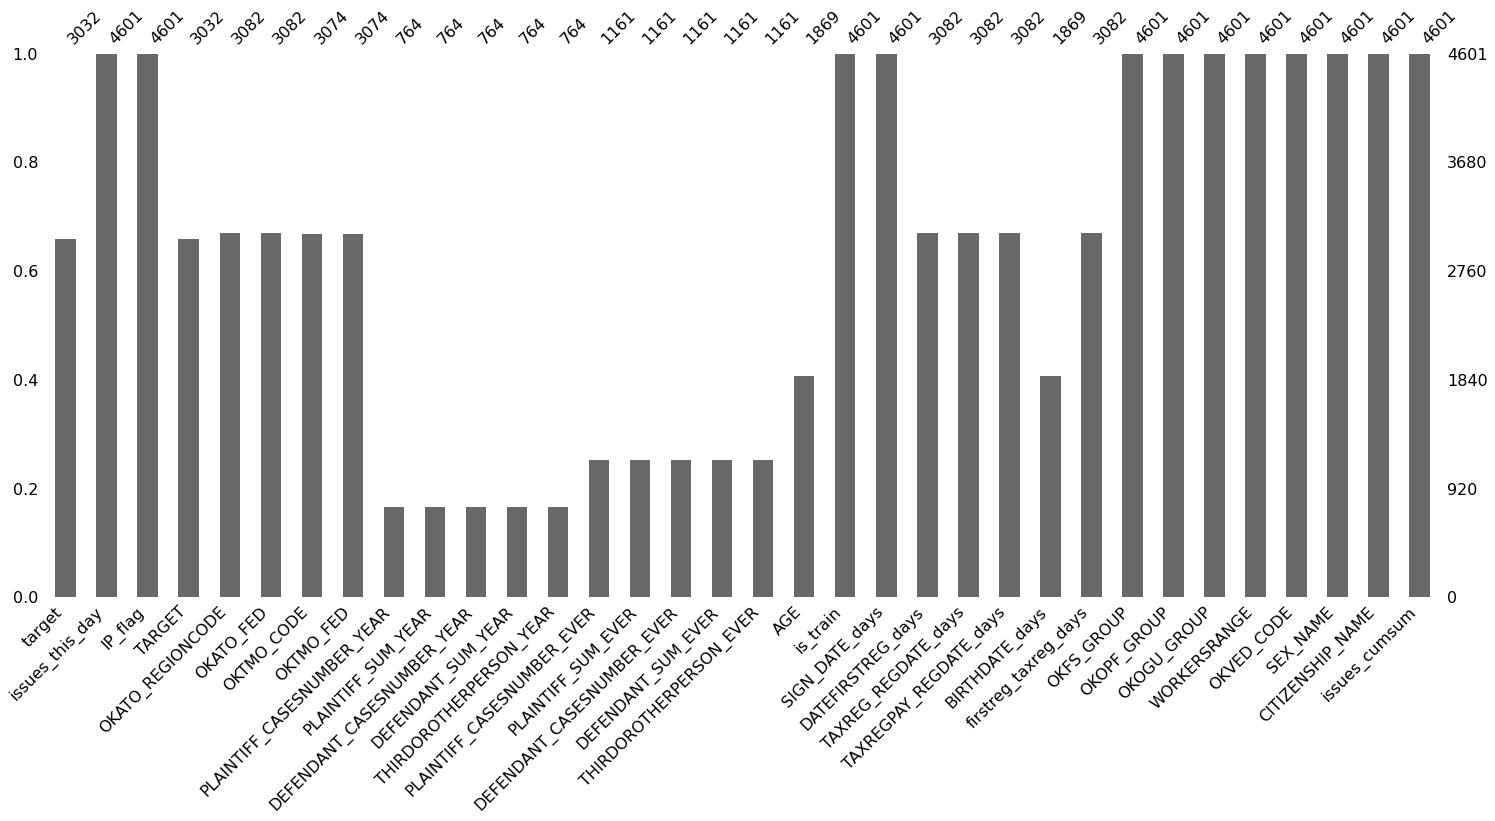

In [82]:
ip_columns_count = ip_data.count()
ip_columns = ip_columns_count[ip_columns_count>0].index.values

ip_data = ip_data[ip_columns]

msno.bar(ip_data)

## EDA

## Модель

In [44]:
# подготавливаем датасеты
ip_test = ip_data[ip_data["is_train"]==0]
ip_train_and_val = ip_data[ip_data["is_train"]==1]

In [45]:
ip_train, ip_val  = train_test_split(ip_train_and_val, stratify=ip_train_and_val["target"])

# ЮЛ

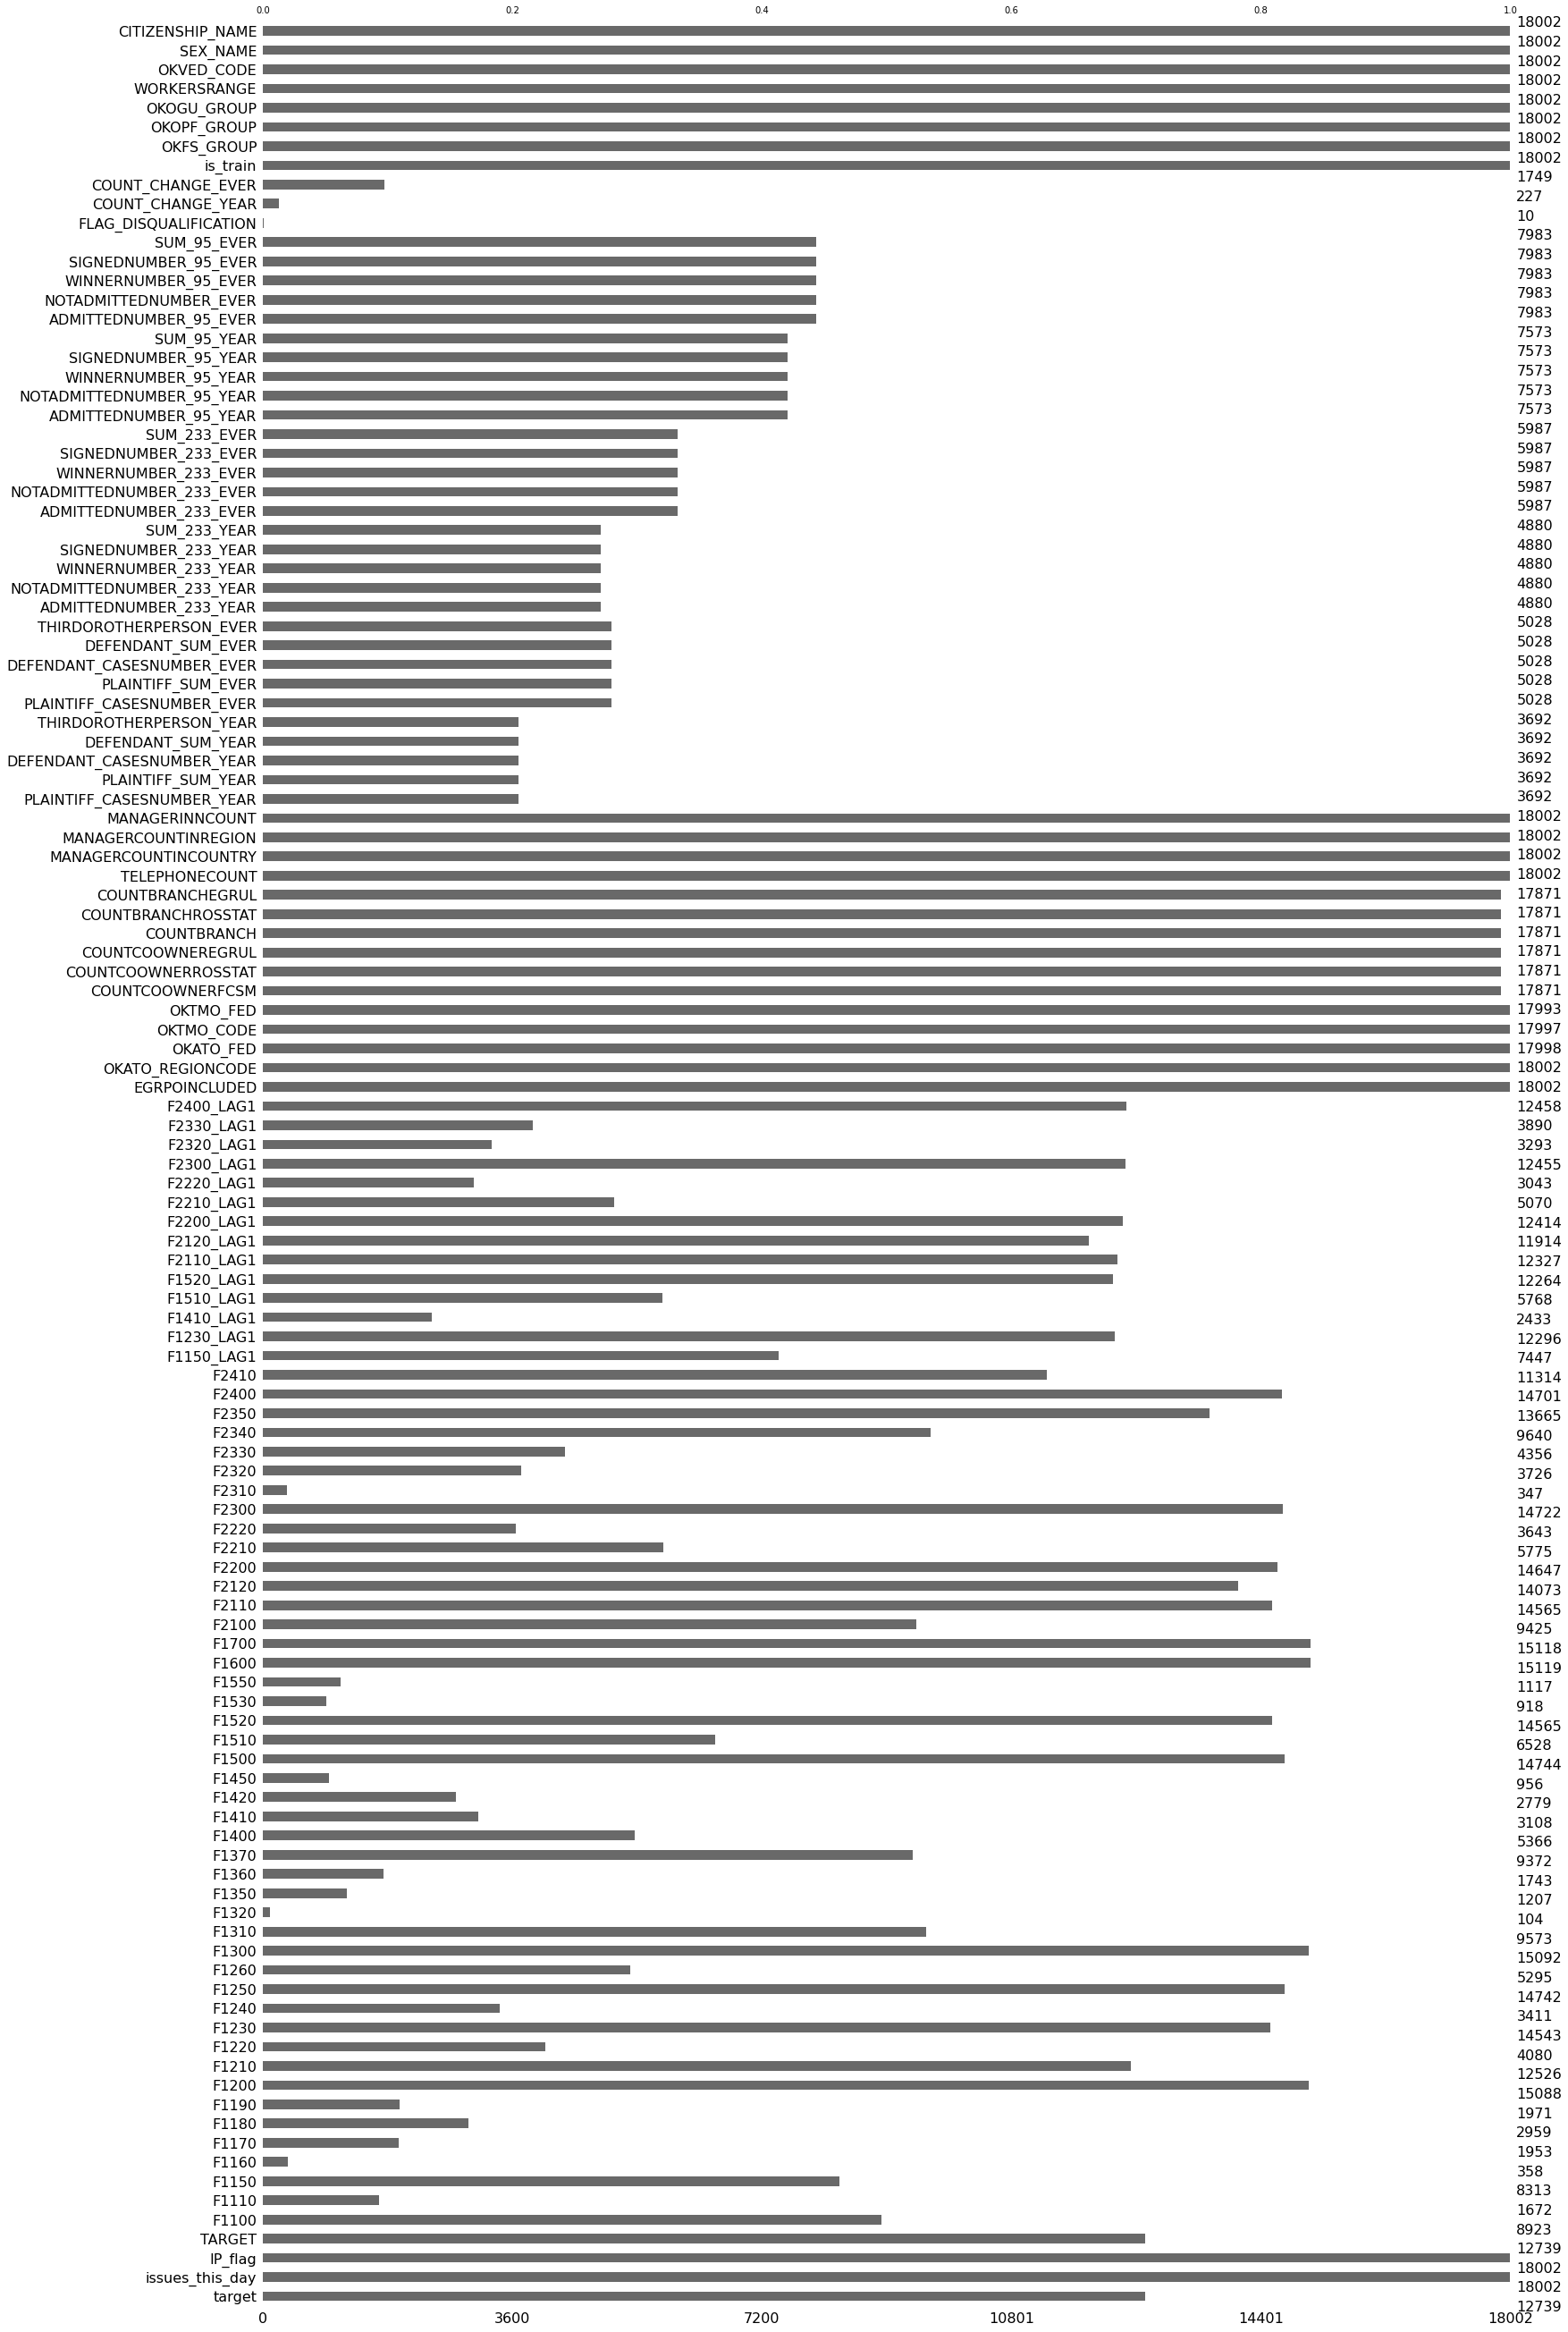

In [ ]:
ul_columns_count = ul_data.count()
ul_columns = ul_columns_count[ul_columns_count>0].index.values

ul_data = ul_data[ul_columns]

msno.bar(ul_data)